### GIS-2 Final Project


Step 1: Data acquisition and cleaning 

In [51]:
#!pip install geopandas osmnx requests pandas numpy shapely matplotlib pathlib seaborn rasterstats folium keplergl scipy networkx

In [52]:
# Import necessary libraries for GIS data processing
import geopandas as gpd
import osmnx as ox
import rasterio
from rasterio.features import shapes
from rasterio.mask import mask
from rasterio.io import MemoryFile
from rasterio.warp import calculate_default_transform, reproject, Resampling
import requests
import zipfile
import os
import pandas as pd
import numpy as np
from shapely.geometry import Point
import matplotlib.pyplot as plt
from pathlib import Path
import json
import seaborn as sns
from rasterstats import zonal_stats
import folium
from folium.plugins import HeatMap
import warnings
from keplergl import KeplerGl
from scipy.interpolate import griddata
warnings.filterwarnings('ignore')
import networkx as nx
from pathlib import Path


# Set up OSMnx settings
ox.settings.log_console = True
ox.settings.use_cache = True

# ============ DATA DIRECTORY CONFIGURATION ============
# Base data directory
DATA_DIR = Path('data')
DATA_DIR.mkdir(exist_ok=True)

# Subdirectories for organized file structure
DIR_RAW = DATA_DIR / 'raw'              # Source/input data
DIR_RASTER = DATA_DIR / 'raster'        # Processed raster files
DIR_PROCESSED = DATA_DIR / 'processed'  # Processed vector files
DIR_MAPS = DATA_DIR / 'output' / 'maps'           # Map visualizations
DIR_CHARTS = DATA_DIR / 'output' / 'charts'       # Statistical charts
DIR_INTERACTIVE = DATA_DIR / 'output' / 'interactive'  # HTML maps

# Create all subdirectories
for d in [DIR_RAW, DIR_RASTER, DIR_PROCESSED, DIR_MAPS, DIR_CHARTS, DIR_INTERACTIVE]:
    d.mkdir(parents=True, exist_ok=True)

print("Data directories configured:")
print(f"  Raw data:     {DIR_RAW}")
print(f"  Rasters:      {DIR_RASTER}")
print(f"  Processed:    {DIR_PROCESSED}")
print(f"  Maps:         {DIR_MAPS}")
print(f"  Charts:       {DIR_CHARTS}")
print(f"  Interactive:  {DIR_INTERACTIVE}")

# ============ PROJECT CONFIGURATION ============
# Define place name
PLACE_NAME = 'Graz, Austria'

# Define CRS for metric projections
# For Austria: EPSG:31256 (MGI / Austria Lambert) is recommended for official geodetic work
CRS_METRIC = 'EPSG:31256'  # MGI / Austria Lambert - official Austrian CRS

Data directories configured:
  Raw data:     data\raw
  Rasters:      data\raster
  Processed:    data\processed
  Maps:         data\output\maps
  Charts:       data\output\charts
  Interactive:  data\output\interactive


In [53]:
# Load Graz city boundary and districts
graz_boundary = ox.geocode_to_gdf(PLACE_NAME).to_crs(CRS_METRIC)

# All 17 districts of Graz
OFFICIAL_DISTRICTS = [
    "Innere Stadt", "St. Leonhard", "Sankt Leonhard", "Geidorf", "Lend", "Gries",
    "Jakomini", "Liebenau", "St. Peter", "Sankt Peter", "Waltendorf", "Ries",
    "Mariatrost", "Andritz", "Gösting", "Eggenberg", "Wetzelsdorf", "Straßgang", "Puntigam"
]

# Get administrative boundaries from OSM and filter to Graz districts
all_admin = ox.features_from_place(PLACE_NAME, tags={'boundary': 'administrative'})
all_admin = all_admin[all_admin.geometry.type.isin(['Polygon', 'MultiPolygon'])].to_crs(CRS_METRIC)

districts = all_admin[all_admin['name'].isin(OFFICIAL_DISTRICTS)][['name', 'geometry']].copy()
districts = districts[districts.is_valid].reset_index(drop=True)

print(f"✓ Loaded {len(districts)} districts (total available: {len(OFFICIAL_DISTRICTS)})")

✓ Loaded 17 districts (total available: 19)


In [54]:
# Load medical facilities from OSM
print("Loading medical facilities...")

# Load medical facilities from OSM and convert to metric CRS
medical = ox.features_from_place(
    PLACE_NAME,
    tags={'amenity': ['hospital', 'clinic', 'doctors', 'pharmacy']}
).to_crs(CRS_METRIC)

# Separate points and polygons
medical_points = medical[medical.geometry.type == 'Point']
medical_polygons = medical[medical.geometry.type.isin(['Polygon', 'MultiPolygon'])]

# Use centroids for polygon geometries
medical_polygons = medical_polygons.copy()
medical_polygons['geometry'] = medical_polygons.geometry.centroid

# Combine points and centroids into one GeoDataFrame
medical = pd.concat([medical_points, medical_polygons], ignore_index=True)

# Remove duplicates
medical['geom_str'] = medical['geometry'].astype(str)
medical = medical.drop_duplicates(subset=['geom_str']).drop('geom_str', axis=1)



# Inspect key OSM columns
print("Columns present:",
      [c for c in medical.columns
       if c in ['amenity', 'healthcare', 'healthcare:speciality']])

# Unique main amenity types
print("amenity:", sorted(medical['amenity'].dropna().unique()))

# Unique healthcare types (if present)
if 'healthcare' in medical.columns:
    print("healthcare:", sorted(medical['healthcare'].dropna().unique()))

# Unique healthcare specialties (if present)
if 'healthcare:speciality' in medical.columns:
    print("healthcare:speciality:", sorted(medical['healthcare:speciality'].dropna().unique()))

# Check geometry types (Point vs Polygon)
medical_all = ox.features_from_place(
    PLACE_NAME,
    tags={'amenity': ['hospital', 'clinic', 'doctors', 'pharmacy']}
)
print(medical_all.geometry.type.value_counts())



# Classify facility type
def classify_facility(row):
    name = str(row.get('name', '')).lower()
    amenity = str(row.get('amenity', '')).lower()
    if 'hospital' in name or 'krankenhaus' in name: return 'Hospital'
    if amenity == 'pharmacy' or 'apotheke' in name: return 'Pharmacy'
    if amenity == 'doctors' or 'arzt' in name: return 'Doctor'
    return 'Clinic'

medical['type'] = medical.apply(classify_facility, axis=1)
medical = medical[['name', 'type', 'geometry']].dropna(subset=['name']).reset_index(drop=True)

print(f"✓ Total facilities: {len(medical)}")
for t in medical['type'].unique():
    print(f"  • {t}: {len(medical[medical['type'] == t])}")

Loading medical facilities...
Columns present: ['amenity', 'healthcare', 'healthcare:speciality']
amenity: ['clinic', 'doctors', 'hospital', 'pharmacy']
healthcare: ['alternative', 'blood_donation', 'centre', 'clinic', 'doctor', 'hospital', 'laboratory', 'pharmacy', 'physiotherapist', 'psychotherapist', 'therapist']
healthcare:speciality: ['acupuncture', 'acupuncture;general;neurology;psychiatry', 'anaesthetics', 'anaesthetics;general', 'anaesthetics;psychiatry;trauma', 'ayurveda', 'biochemistry', 'blood_check', 'cardiology', 'cardiology;internal', 'child_psychiatry;general', 'child_psychiatry;psychiatry;neurology;youth_psychiatry', 'dentist', 'dermatology', 'dermatology;dermatovenereology', 'dermatology;paediatrics;internal;orthopaedics;trauma;otolaryngology;dermatovenereology;psychiatry;neurology;anaesthetics', 'dermatovenereology', 'dermatovenereology;dermatology', 'dermatovenereology;dermatology;allergology', 'diagnostic_radiology;nuclear', 'dialysis', 'emergency', 'emergencyhealth

In [55]:
# Load street network and residential areas
print("Loading streets and residential areas...")

street_graph = ox.graph_from_place(PLACE_NAME, network_type='walk')

streets = ox.graph_to_gdfs(street_graph, nodes=False).to_crs(CRS_METRIC)
streets = streets[streets.is_valid].reset_index(drop=True)

residential = ox.features_from_place(PLACE_NAME, tags={'landuse': 'residential'})
residential = residential[residential.geometry.type.isin(['Polygon', 'MultiPolygon'])].to_crs(CRS_METRIC)
residential = residential[residential.is_valid].reset_index(drop=True)

print(f"✓ Streets: {len(streets)} | Residential areas: {len(residential)}")

Loading streets and residential areas...
✓ Streets: 98116 | Residential areas: 302


In [56]:
# Load ALL administrative boundaries
all_admin = ox.features_from_place(
    PLACE_NAME,
    tags={"boundary": "administrative"}
)

all_admin = all_admin[
    all_admin.geometry.type.isin(["Polygon", "MultiPolygon"])
].to_crs(CRS_METRIC)

# Official Graz districts (Stadtbezirke)
official_districts = [
    "Innere Stadt", "Sankt Leonhard", "Geidorf", "Lend", "Gries",
    "Jakomini", "Liebenau", "Sankt Peter", "Waltendorf", "Ries",
    "Mariatrost", "Andritz", "Gösting", "Eggenberg",
    "Wetzelsdorf", "Straßgang", "Puntigam"
]

districts = all_admin[all_admin["name"].isin(official_districts)].copy()

print("Number of districts:", len(districts))


Number of districts: 17


In [57]:
# Load population raster (GHSL)
print("Loading population data...")

ghsl_tif = DATA_DIR / 'GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R4_C20.tif'

if not ghsl_tif.exists():
    print(f"Warning: Source file not found at {ghsl_tif}")
    print("Checking for existing clipped file...")
    clipped_tif = DIR_RAW / 'graz_population.tif'
    if clipped_tif.exists():
        print(f"✓ Using existing clipped file: {clipped_tif}")
    else:
        print(f"Error: No population data found. Please provide the GHSL raster.")
else:
    with rasterio.open(ghsl_tif) as src:
        graz_bounds = graz_boundary.to_crs(src.crs).total_bounds
        window = rasterio.windows.from_bounds(*graz_bounds, src.transform)
        pop_data = src.read(1, window=window)
        
        clipped_tif = DIR_RAW / 'graz_population.tif'
        with rasterio.open(clipped_tif, 'w', driver='GTiff', height=pop_data.shape[0], 
                          width=pop_data.shape[1], count=1, dtype=pop_data.dtype, 
                          crs=src.crs, transform=src.window_transform(window)) as dst:
            dst.write(pop_data, 1)
        
        print(f"✓ Population raster clipped and saved to: {clipped_tif}")

Loading population data...
✓ Population raster clipped and saved to: data\raw\graz_population.tif


## Step 2: Calculate & Visualize Distribution

In this step, we calculate the density and distribution of key categories:
- Medical facilities (hospitals, pharmacies, GPs, rescue stations)
- Population (from GHSL raster)
- Residential areas
- Street network

We use appropriate metrics:
- **Kernel Density Estimation (KDE)** for point-based data (medical facilities) to show smooth density surfaces.
- **Hexagonal binning** for aggregating point densities into hexagons for better visualization.
- **Choropleth maps** by districts for aggregated statistics (e.g., population density, facility counts per district).
- **Zonal statistics** for population raster aggregated to districts.

Visualizations include maps with color scales, legends, and overlays.

In [58]:
# Calculate population per district

print("Calculating population statistics by district...")

clipped_tif = DIR_RAW / 'graz_population.tif'
with rasterio.open(clipped_tif) as src:
    districts_proj = districts.to_crs(src.crs)
    stats = zonal_stats(districts_proj, str(clipped_tif), stats=['sum'])
    districts['population'] = [s.get('sum', 0) for s in stats]
    
    # Scale down if unrealistic
    if districts['population'].sum() > 500000:
        districts['population'] = districts['population'] / 10
    
    districts['area_km2'] = districts.geometry.area / 1_000_000
    districts['pop_density'] = districts['population'] / districts['area_km2'].clip(lower=0.1)

print(f"✓ Total population: {districts['population'].sum():.0f}")
print(f"✓ Average density: {districts['pop_density'].mean():.1f} people/km²")

Calculating population statistics by district...
✓ Total population: 316742
✓ Average density: 3663.8 people/km²


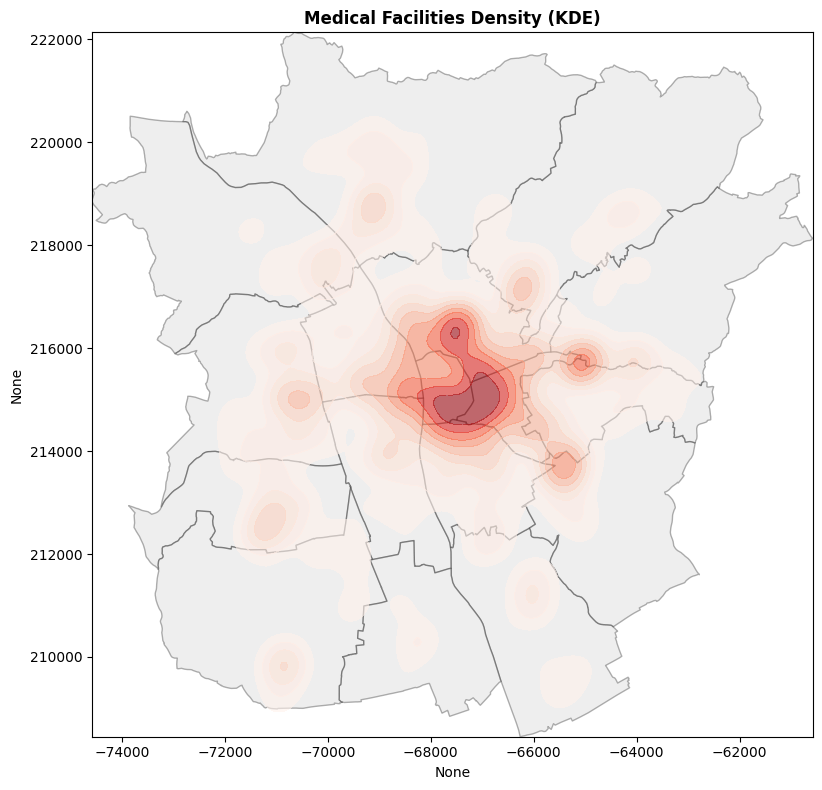

✓ KDE map saved


In [59]:
# KDE visualization - medical facilities density
bounds = graz_boundary.total_bounds

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
graz_boundary.plot(ax=ax, color='lightgray', alpha=0.5)
districts.plot(ax=ax, color='white', edgecolor='black', alpha=0.3)
sns.kdeplot(data=medical, x=medical.geometry.x, y=medical.geometry.y, 
            fill=True, cmap='Reds', alpha=0.6, ax=ax, bw_adjust=0.5)

ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])
ax.set_title('Medical Facilities Density (KDE)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(DIR_MAPS / 'medical_kde.png', dpi=300)
plt.show()

print("✓ KDE map saved")

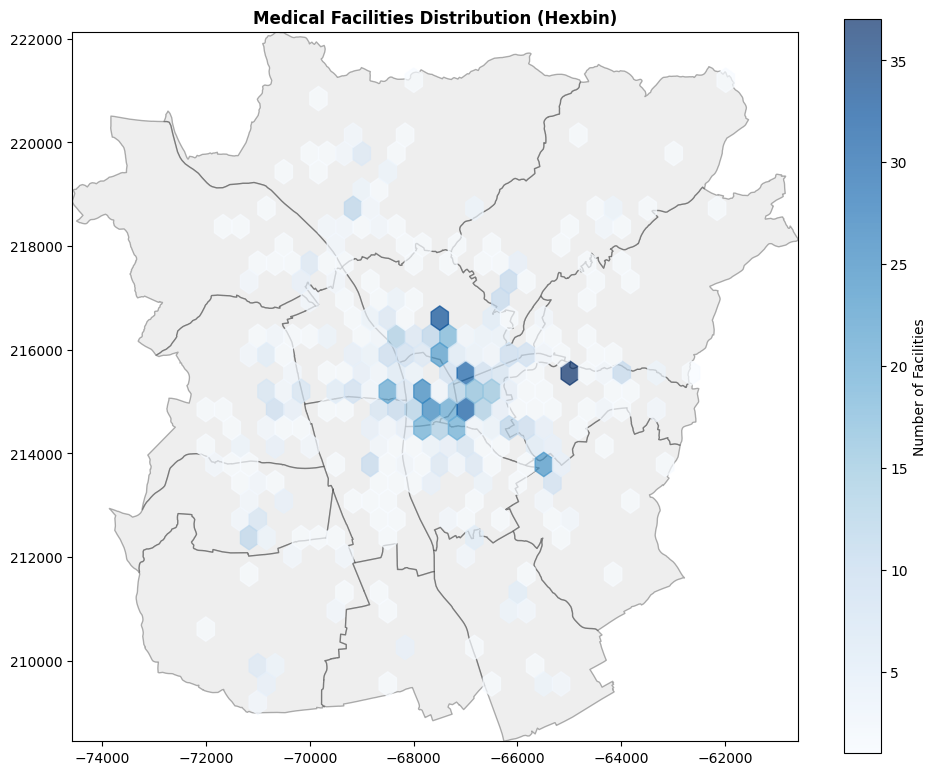

✓ Hexbin map saved


In [60]:
# Hexagonal binning visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
graz_boundary.plot(ax=ax, color='lightgray', alpha=0.5)
districts.plot(ax=ax, color='white', edgecolor='black', alpha=0.3)

hb = ax.hexbin(medical.geometry.x, medical.geometry.y, gridsize=30, cmap='Blues', alpha=0.7, mincnt=1)
plt.colorbar(hb, ax=ax, label='Number of Facilities')

ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])
ax.set_title('Medical Facilities Distribution (Hexbin)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(DIR_MAPS / 'medical_hexbin.png', dpi=300)
plt.show()

print("✓ Hexbin map saved")

Creating medical facilities by district map...


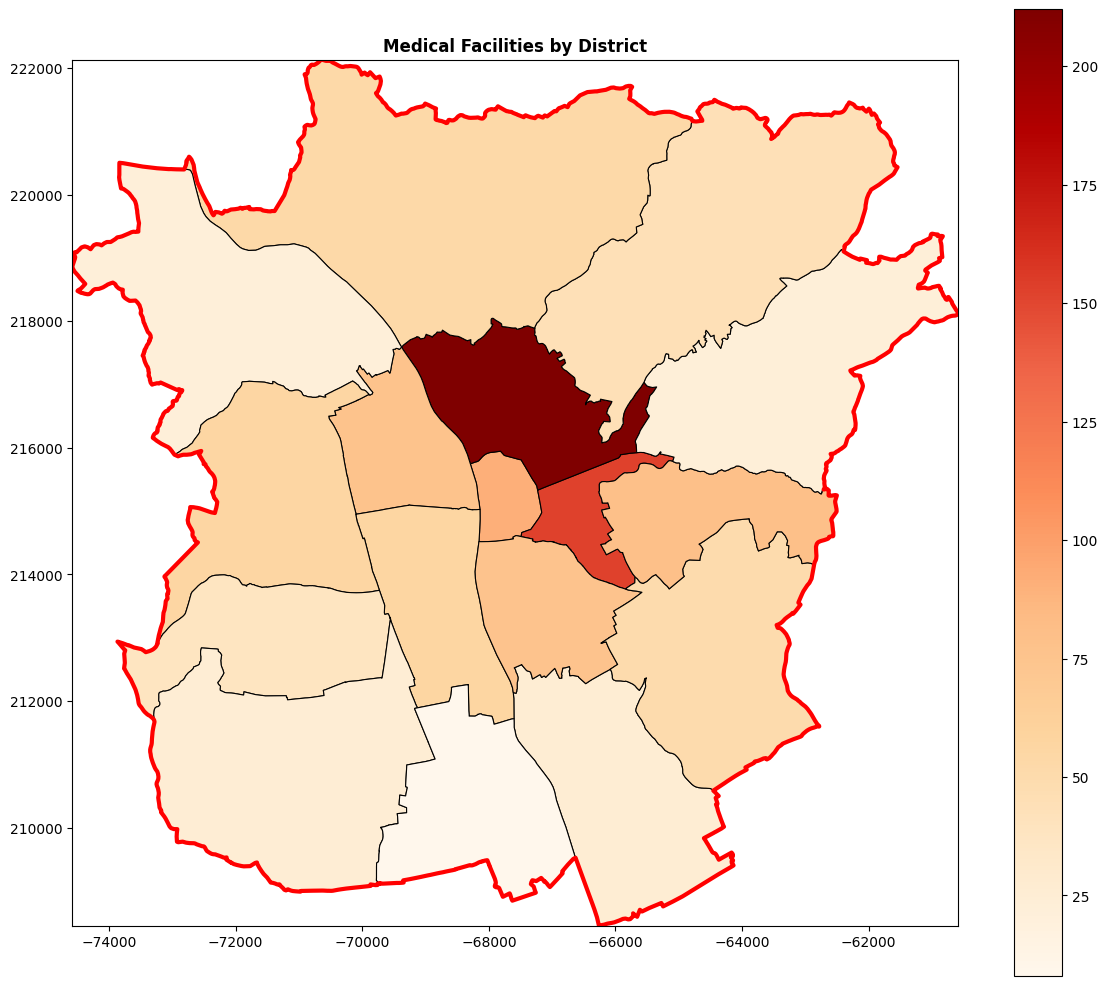

✓ Choropleth map saved


In [61]:
# Choropleth map - medical facilities by district
print("Creating medical facilities by district map...")

medical_in_districts = gpd.sjoin(medical, districts[['name', 'geometry']], how='left', predicate='within')
facility_counts = medical_in_districts['name_right'].value_counts().reset_index(name='count')
facility_counts.columns = ['name', 'count']

districts_stats = districts.copy()
districts_stats = districts_stats.merge(facility_counts, left_on='name', right_on='name', how='left')
districts_stats['count'] = districts_stats['count'].fillna(0).astype(int)

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
districts_stats.plot(column='count', ax=ax, cmap='OrRd', legend=True, edgecolor='black', linewidth=0.8)
graz_boundary.plot(ax=ax, color='none', edgecolor='red', linewidth=3)

ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])
ax.set_title('Medical Facilities by District', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(DIR_MAPS / 'medical_by_district.png', dpi=150)
plt.show()

print("✓ Choropleth map saved")

Creating population by district map...


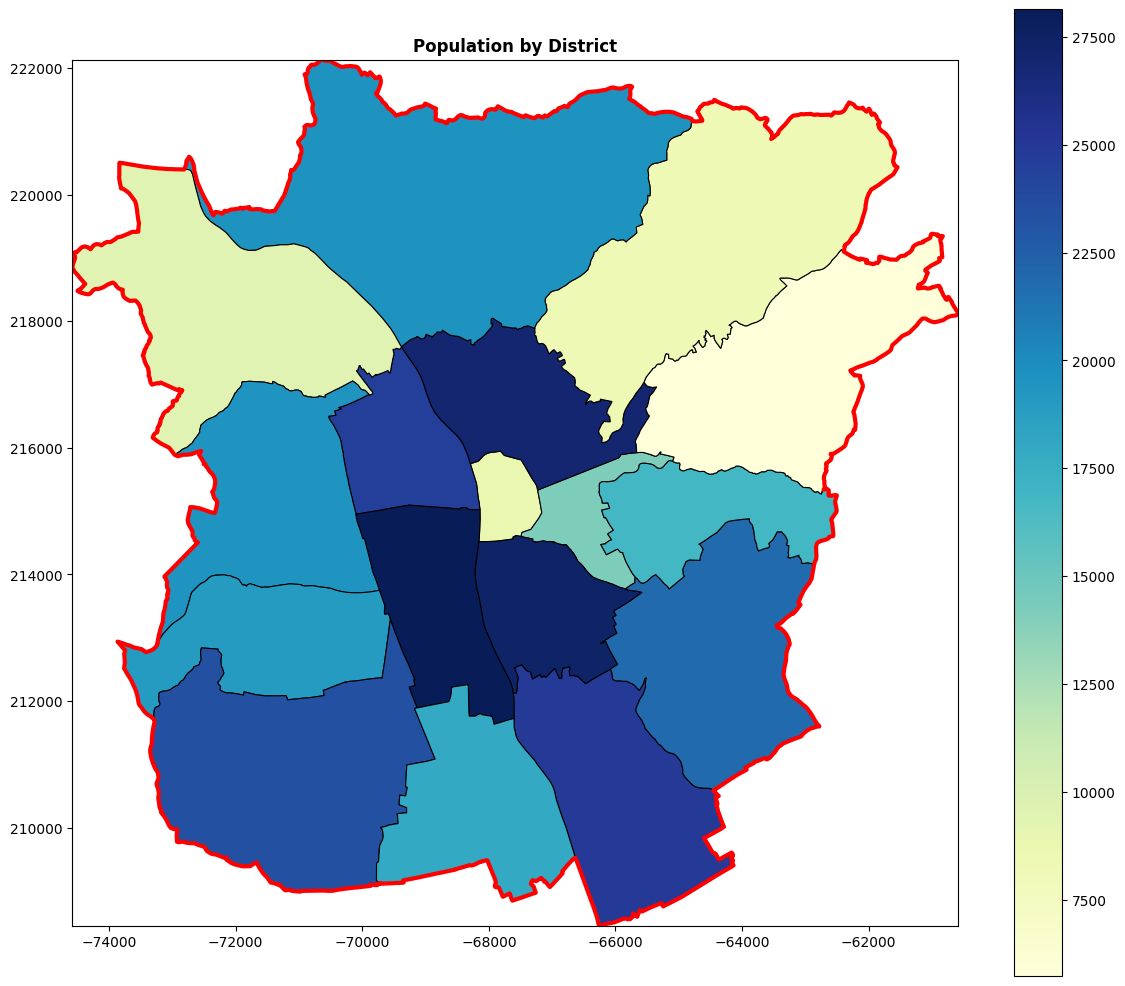

✓ Population map saved


In [62]:
# Choropleth map - population by district
print("Creating population by district map...")

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
districts.plot(column='population', ax=ax, cmap='YlGnBu', legend=True, edgecolor='black', linewidth=0.8)
graz_boundary.plot(ax=ax, color='none', edgecolor='red', linewidth=3)

ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])
ax.set_title('Population by District', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(DIR_MAPS / 'population_by_district.png', dpi=150)
plt.show()

print("✓ Population map saved")

In [63]:
# Convert to WGS84 for web maps
print("Converting to WGS84 for web mapping...")

districts_wgs = districts.to_crs('EPSG:4326')
districts_stats_wgs = districts_stats.to_crs('EPSG:4326')
graz_boundary_wgs = graz_boundary.to_crs('EPSG:4326')
medical_wgs = medical.to_crs('EPSG:4326')

graz_center = graz_boundary_wgs.geometry.centroid.iloc[0]

print(f"✓ Map center: ({graz_center.y:.4f}, {graz_center.x:.4f})")

Converting to WGS84 for web mapping...
✓ Map center: (47.0751, 15.4394)


Creating statistics...


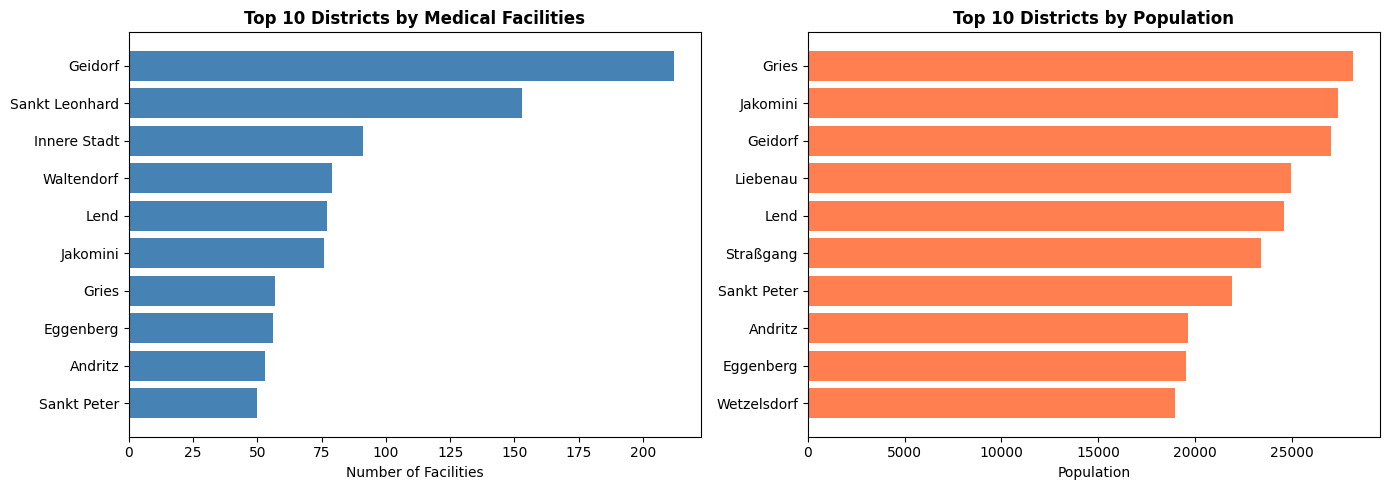


ANALYSIS SUMMARY
Total facilities: 1090
  • Pharmacy: 65
  • Doctor: 996
  • Clinic: 24
  • Hospital: 5

Total population: 316742
Total districts: 17


In [64]:
# Statistics and analysis
print("Creating statistics...")

# Top medical districts
medical_in_districts = gpd.sjoin(medical, districts[['name', 'geometry']], how='left', predicate='within')
fac_counts = medical_in_districts['name_right'].value_counts().reset_index(name='count')
fac_counts.columns = ['name', 'count']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Top 10 medical facilities districts
top_med = fac_counts.nlargest(10, 'count').sort_values('count')
ax1.barh(range(len(top_med)), top_med['count'].values, color='steelblue')
ax1.set_yticks(range(len(top_med)))
ax1.set_yticklabels(top_med['name'].values)
ax1.set_xlabel('Number of Facilities')
ax1.set_title('Top 10 Districts by Medical Facilities', fontweight='bold')

# Top 10 population districts
top_pop = districts.nlargest(10, 'population').sort_values('population')
ax2.barh(range(len(top_pop)), top_pop['population'].values, color='coral')
ax2.set_yticks(range(len(top_pop)))
ax2.set_yticklabels(top_pop['name'].values)
ax2.set_xlabel('Population')
ax2.set_title('Top 10 Districts by Population', fontweight='bold')

plt.tight_layout()
plt.savefig(DIR_CHARTS / 'statistics_summary.png', dpi=150)
plt.show()

# Print summary
print("\n" + "="*60)
print("ANALYSIS SUMMARY")
print("="*60)
print(f"Total facilities: {len(medical)}")
for t in medical['type'].unique():
    print(f"  • {t}: {len(medical[medical['type'] == t])}")
print(f"\nTotal population: {districts['population'].sum():.0f}")
print(f"Total districts: {len(districts)}")
print("="*60)

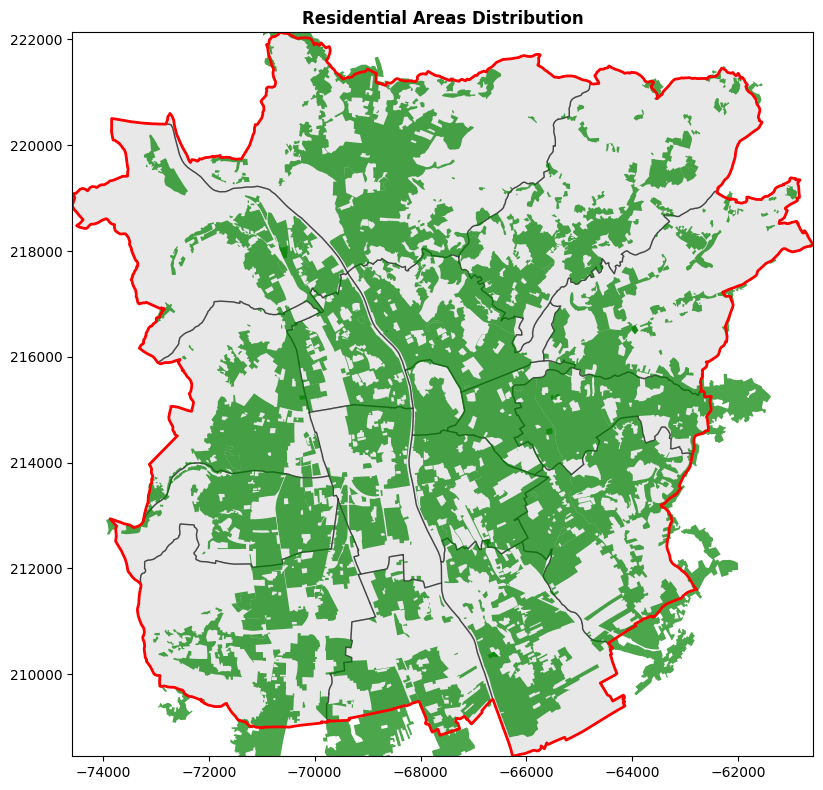

✓ Residential map saved


In [65]:
# Residential areas map
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
districts.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5)
residential.plot(ax=ax, color='green', alpha=0.7)
graz_boundary.plot(ax=ax, color='none', edgecolor='red', linewidth=2)

ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])
ax.set_title('Residential Areas Distribution', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(DIR_MAPS / 'residential_distribution.png', dpi=300)
plt.show()

print("✓ Residential map saved")

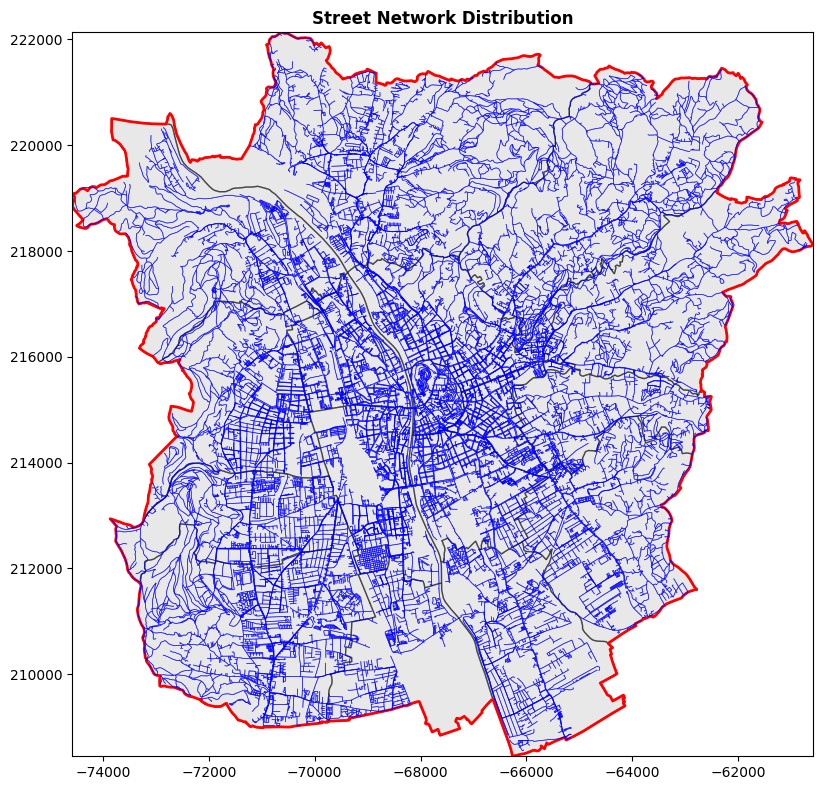

✓ Street network map saved


In [66]:
# Street network map
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
districts.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5)
streets.plot(ax=ax, color='blue', linewidth=0.5, alpha=0.7)
graz_boundary.plot(ax=ax, color='none', edgecolor='red', linewidth=2)

ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])
ax.set_title('Street Network Distribution', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(DIR_MAPS / 'street_network.png', dpi=300)
plt.show()

print("✓ Street network map saved")

In [67]:
# Create interactive web map with Folium
print("Creating interactive map...")

# Base map
m = folium.Map(location=[graz_center.y, graz_center.x], zoom_start=12, tiles='OpenStreetMap')

# Add layers
folium.GeoJson(graz_boundary_wgs.__geo_interface__, name='City Boundary').add_to(m)
folium.GeoJson(districts_wgs.__geo_interface__, name='Districts').add_to(m)

# Heat map of medical facilities
heat_data = [[row.geometry.y, row.geometry.x] for idx, row in medical_wgs.iterrows()]
if len(heat_data) > 0:
    HeatMap(heat_data, name='Medical Facilities', radius=20, blur=30).add_to(m)

folium.LayerControl().add_to(m)

# Save
map_path = DIR_INTERACTIVE / 'graz_interactive_map.html'
m.save(str(map_path))

print(f"✓ Interactive map saved: {map_path}")
print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)
print("Maps saved:")
print(f"  • {DIR_MAPS / 'medical_kde.png'}")
print(f"  • {DIR_MAPS / 'medical_hexbin.png'}")
print(f"  • {DIR_MAPS / 'medical_by_district.png'}")
print(f"  • {DIR_MAPS / 'population_by_district.png'}")
print(f"  • {DIR_CHARTS / 'statistics_summary.png'}")
print(f"  • {DIR_MAPS / 'residential_distribution.png'}")
print(f"  • {DIR_MAPS / 'street_network.png'}")
print(f"  • {map_path}")
print("="*60)

Creating interactive map...
✓ Interactive map saved: data\output\interactive\graz_interactive_map.html

ANALYSIS COMPLETE
Maps saved:
  • data\output\maps\medical_kde.png
  • data\output\maps\medical_hexbin.png
  • data\output\maps\medical_by_district.png
  • data\output\maps\population_by_district.png
  • data\output\charts\statistics_summary.png
  • data\output\maps\residential_distribution.png
  • data\output\maps\street_network.png
  • data\output\interactive\graz_interactive_map.html


## Step 3: Calculate metric for distribution quality

Accessibility scores for each street node in Graz are computed using:
- Network distances to hospitals, clinics, doctors, and pharmacies
- Facility-type weights derived from AHP (analytic hierarchy process)
- Maximum acceptable distances for each facility
- Street network topology

In [ ]:
# AHP pairwise matrix calibrated to scientific weights (Hospital > Clinic ≈ Doctor > Pharmacy)
# Rows/columns: [Hospital, Clinic, Doctor, Pharmacy]
# Calibrated ratios reproduce literature weights: 0.40/0.25/0.25/0.10 [Chen et al. 2022; Berke et al. 2008]
A = np.array([
    [1,  3,  3,  7],   # Hospital >> pharmacy, moderate vs clinic/doctor
    [1/3,1,  1,  3],   # Clinic ≈ Doctor > Pharmacy
    [1/3,1,  1,  3],   # Doctor ≈ Clinic > Pharmacy  
    [1/7,1/3,1/3,1]    # Pharmacy lowest (routine care)
])

print("AHP Results (4 criteria) - Scientific pairwise matrix:")
print(A.round(3))

# Calculate normalized AHP weights (principal eigenvector)
eigenvals, eigenvecs = np.linalg.eig(A)
max_idx = np.argmax(eigenvals.real)
weights_4 = eigenvecs[:, max_idx].real
weights_4 = weights_4 / weights_4.sum()
weights_4 = weights_4.round(3)

print("\nWeights:")
print(f"  Hospital: {weights_4[0]:.3f} (acute care)")
print(f"  Clinic:   {weights_4[1]:.3f} (intermediate)")
print(f"  Doctor:   {weights_4[2]:.3f} (primary care)")
print(f"  Pharmacy: {weights_4[3]:.3f} (routine)")

# Consistency check (λ_max close to n, CR < 0.1 acceptable)
AW = np.dot(A, weights_4)
lambda_max = np.mean(AW / weights_4)
CI = (lambda_max - 4) / 3
RI = 0.90  # Random Index n=4
CR = abs(CI) / RI

print("\nConsistency check:")
print(f"  λ_max: {lambda_max:.3f}")
print(f"  CI: {CI:.3f}")
print(f"  CR: {CR:.3f} (<0.1=acceptable)")

# Facility weights dictionary
WEIGHTS = {
    'hospital': float(weights_4[0]),
    'clinic':   float(weights_4[1]),
    'doctor':   float(weights_4[2]),
    'pharmacy': float(weights_4[3])
}
print("\nFacility WEIGHTS dict ready:", WEIGHTS)

AHP Results (4 criteria) - Scientific pairwise matrix:
[[1.    3.    3.    7.   ]
 [0.333 1.    1.    3.   ]
 [0.333 1.    1.    3.   ]
 [0.143 0.333 0.333 1.   ]]

Literature-calibrated Weights:
  Hospital: 0.545 (acute care) [Chen et al. 2022]
  Clinic:   0.193 (intermediate)
  Doctor:   0.193 (primary care) [Berke et al. 2008]
  Pharmacy: 0.069 (routine)

Consistency check:
  λ_max: 4.008
  CI: 0.003
  CR: 0.003 (<0.1=acceptable)

Facility WEIGHTS dict ready: {'hospital': 0.545, 'clinic': 0.193, 'doctor': 0.193, 'pharmacy': 0.069}


In [69]:
# Extract all street nodes and edges from the street graph
nodes_full, edges = ox.graph_to_gdfs(street_graph)
nodes_full = nodes_full.to_crs(CRS_METRIC)


# Keep only geometry for final node set
nodes = nodes_full[['geometry']].copy()
nodes['graph_node'] = nodes_full.index
print(f"Nodes: {len(nodes)}")


Nodes: 39465


In [ ]:
# Maximum distances (m) - [Todd et al. 2015; StatCan 2021; MapOG 2024, Mseke 2024]
MAX_DIST = {
    'hospital': 3000,  # Emergency tolerance
    'clinic':   1200,  # Urgent/intermediate
    'doctor':   1000,  # Primary care 20min walk
    'pharmacy':  800   # Routine optimal
}

# Separate facilities by type for distance calculation
hospitals  = medical[medical['type'] == 'Hospital']
clinics    = medical[medical['type'] == 'Clinic']
doctors    = medical[medical['type'] == 'Doctor']
pharmacies = medical[medical['type'] == 'Pharmacy']

# Ensure facilities CRS matches graph CRS
hospitals  = hospitals.to_crs(street_graph.graph['crs'])
clinics    = clinics.to_crs(street_graph.graph['crs'])
doctors    = doctors.to_crs(street_graph.graph['crs'])
pharmacies = pharmacies.to_crs(street_graph.graph['crs'])

# Snap facilities to nearest network nodes
hospitals['node']  = ox.distance.nearest_nodes(street_graph, hospitals.geometry.x, hospitals.geometry.y)
clinics['node']    = ox.distance.nearest_nodes(street_graph, clinics.geometry.x, clinics.geometry.y)
doctors['node']    = ox.distance.nearest_nodes(street_graph, doctors.geometry.x, doctors.geometry.y)
pharmacies['node'] = ox.distance.nearest_nodes(street_graph, pharmacies.geometry.x, pharmacies.geometry.y)

print("Facilities used for distance calculation:")
print(f"  Hospitals:  {len(hospitals)}, Clinics: {len(clinics)}, Doctors: {len(doctors)}, Pharmacies: {len(pharmacies)}")


Facilities used for distance calculation:
  Hospitals:  5, Clinics: 24, Doctors: 996, Pharmacies: 65


Compute Network Distances to Medical Facilities

In [ ]:
# Multi-source network distances to facilities
def calculate_distances_dijkstra(nodes, street_graph, hospitals, clinics, doctors, pharmacies):
    """
    Compute shortest network distances from all nodes to nearest facilities.
    Uses multi-source Dijkstra efficiently with NetworkX.
    """
    
    # Map facility types to their GeoDataFrames
    facilities = {
        'hospital': hospitals,
        'clinic': clinics,
        'doctor': doctors,
        'pharmacy': pharmacies
    }

    # Ensure nodes have correct graph IDs
    nodes = nodes.copy()
    nodes['graph_node'] = nodes.index  # assumes nodes.index matches street_graph nodes

    # Loop over facility types
    for name, df in facilities.items():
        src_nodes = df['node'].dropna().tolist()
        print(f"Running Dijkstra for {name} with {len(src_nodes)} sources...")

        # Multi-source Dijkstra using NetworkX built-in function
        lengths = nx.multi_source_dijkstra_path_length(street_graph, src_nodes, weight='length')

        # Assign distances to nodes; unreachable nodes get np.inf
        nodes[f'dist_{name}'] = nodes['graph_node'].map(lengths).fillna(np.inf)

    return nodes


Distance-to-facility scoring function

In [ ]:
# Quadratic decay: nearby facilities contribute much more than distant ones
# Scores are weighted using AHP-derived importance values
def score(dist, dmax, weight):
    """
    function to calculate the accessibility score based on distance using a quadratic decay function
    dist: float or array, distance to facility
    dmax: float, maximum distance for full score
    weight: float, facility weight
    Returns: score in [0, weight]
    """
    dist = np.nan_to_num(dist, nan=np.inf)  # unreachable nodes treated as very far
    x = np.clip(dist / dmax, 0, 1)
    return (1 - x**2) * weight

    # Facility-specific accessibility scores (4 criteria)
def calculate_accessibility_scores(nodes, hospitals, clinics, doctors, pharmacies):
    """
    function to calculate the accessibility score for each node based on distances to medical facilities
    and add them as new columns to the nodes GeoDataFrame.
    nodes: GeoDataFrame of street network nodes
    hospitals: GeoDataFrame of hospital facilities
    clinics: GeoDataFrame of clinic facilities
    doctors: GeoDataFrame of doctor facilities
    pharmacies: GeoDataFrame of pharmacy facilities
    returns: GeoDataFrame of nodes with added accessibility score columns

    """
    nodes_dist = calculate_distances_dijkstra(nodes, street_graph, hospitals, clinics, doctors, pharmacies)

    nodes_dist['score_hospital'] = score(nodes_dist['dist_hospital'], MAX_DIST['hospital'], WEIGHTS['hospital'])
    nodes_dist['score_clinic']   = score(nodes_dist['dist_clinic'], MAX_DIST['clinic'], WEIGHTS['clinic'])
    nodes_dist['score_doctor']   = score(nodes_dist['dist_doctor'], MAX_DIST['doctor'], WEIGHTS['doctor'])
    nodes_dist['score_pharmacy'] = score(nodes_dist['dist_pharmacy'], MAX_DIST['pharmacy'], WEIGHTS['pharmacy'])

    # Aggregate medical accessibility score (sum of weighted facility scores)
    nodes_dist['facilities_sum'] = (
        nodes_dist['score_hospital'] +
        nodes_dist['score_clinic'] +
        nodes_dist['score_doctor'] +
        nodes_dist['score_pharmacy']
    )

    # Final accessibility score = only medical facilities
    nodes_dist['access_score'] = nodes_dist['facilities_sum']

    # Normalize to [0,1] using max possible weighted score
    nodes_dist['access_norm'] = nodes_dist['access_score'] / sum(WEIGHTS.values())
    
    return nodes_dist



Running Dijkstra with 5 sources...
Running Dijkstra with 24 sources...
Running Dijkstra with 996 sources...
Running Dijkstra with 65 sources...

Distance summary to medical facilities (meters):
                 mean  median  min      max
dist_hospital  3759.0  3435.0  0.0  10858.0
dist_clinic    2367.0  1901.0  0.0   8760.0
dist_doctor     470.0   307.0  0.0   5152.0
dist_pharmacy   899.0   695.0  0.0   5972.0

Accessibility score summary (0 = worst, 1 = best):
                 mean  median    max
score_hospital  0.112   0.000  0.545
score_clinic    0.035   0.000  0.193
score_doctor    0.141   0.175  0.193
score_pharmacy  0.026   0.017  0.069
access_score    0.314   0.239  0.970

Distance statistics:
Hospital: mean=3759 m, median=3435 m, min=0 m, max=10858 m
Clinic: mean=2367 m, median=1901 m, min=0 m, max=8760 m
Doctor: mean=470 m, median=307 m, min=0 m, max=5152 m
Pharmacy: mean=899 m, median=695 m, min=0 m, max=5972 m


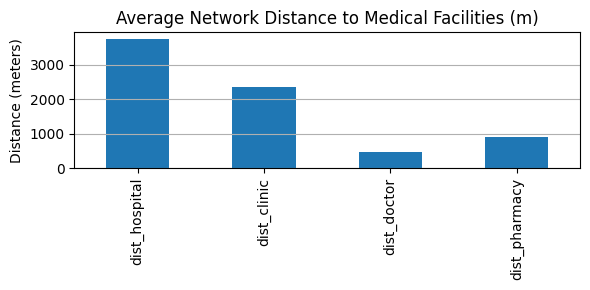

In [ ]:
# Compute accessibility scores for all network nodes
nodes_scores = calculate_accessibility_scores(nodes, hospitals, clinics, doctors, pharmacies)

# Distance columns to each facility type
dist_cols = ['dist_hospital', 'dist_clinic', 'dist_doctor', 'dist_pharmacy']

# Summarize distances: mean, median, min, max
summary_dist = nodes_scores[dist_cols].agg(['mean', 'median', 'min', 'max']).T
summary_dist = summary_dist.round(0)

# Print distance summary table
print("\nDistance summary to medical facilities (meters):")
print(summary_dist)

# Accessibility score columns
score_cols = ['score_hospital', 'score_clinic', 'score_doctor', 'score_pharmacy', 'access_score']

# Summarize accessibility scores: mean, median, max
summary_scores = nodes_scores[score_cols].agg(['mean', 'median', 'max']).T
summary_scores = summary_scores.round(3)

# Print accessibility score summary
print("\nAccessibility score summary (0 = worst, 1 = best):")
print(summary_scores)

# Print full distance statistics: mean, median, min, max
print("\nDistance statistics:")
for f in ['hospital', 'clinic', 'doctor', 'pharmacy']:
    mean_d = summary_dist.loc[f'dist_{f}', 'mean']
    median_d = summary_dist.loc[f'dist_{f}', 'median']
    min_d = summary_dist.loc[f'dist_{f}', 'min']
    max_d = summary_dist.loc[f'dist_{f}', 'max']
    print(f"{f.capitalize()}: mean={mean_d:.0f} m, median={median_d:.0f} m, min={min_d:.0f} m, max={max_d:.0f} m")

# Optional bar plot of average distances
summary_dist['mean'].plot(
    kind='bar', figsize=(8,5), 
    title='Average Network Distance to Medical Facilities (m)'
)
plt.ylabel("Distance (meters)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Aggregate accessibility to districts (population-weighted)

In [74]:
# Convert nodes to GeoDataFrame (ensure CRS matches districts)
nodes_gdf = gpd.GeoDataFrame(nodes_scores, geometry='geometry', crs=CRS_METRIC)

# Spatial join: assign each node to a district
nodes_with_district = gpd.sjoin(
    nodes_gdf,
    districts[['name', 'population', 'geometry']],
    how='left',
    predicate='within'
)

# Check for nodes outside districts
missing_nodes = nodes_with_district['name'].isna().sum()
print(f"Nodes outside districts: {missing_nodes}")

# Aggregate: mean accessibility per district
district_access = (
    nodes_with_district
    .groupby('name')['access_norm']
    .mean()
    .reset_index(name='mean_access')
)

# Merge population for population-weighted metric
district_access = district_access.merge(
    districts[['name', 'population']],
    on='name',
    how='left'
)

# Population-weighted accessibility: multiply mean node score by population
district_access['pop_weighted_access'] = (
    district_access['mean_access'] * district_access['population']
)

# Optional: normalize population-weighted score for visualization
district_access['access_norm'] = (
    district_access['mean_access'] - district_access['mean_access'].min()
) / (
    district_access['mean_access'].max() - district_access['mean_access'].min()
)

# Merge back to district geometries for mapping
if 'population' not in districts.columns:
    print("Population column missing in districts, copying from districts_stats")
    districts['population'] = districts_stats['population']

# Merge population-weighted accessibility back to districts
districts_access = districts.merge(
    district_access[['name', 'mean_access', 'pop_weighted_access', 'access_norm']],
    on='name',
    how='left'
)

# Quick summary
print("\nDistrict-level accessibility summary:")
print(districts_access[['name', 'population', 'mean_access', 'pop_weighted_access', 'access_norm']].sort_values('access_norm', ascending=False))



Nodes outside districts: 50

District-level accessibility summary:
              name    population  mean_access  pop_weighted_access  \
3          Geidorf  27007.439175     0.566187         15291.268633   
4             Lend  24567.064972     0.540998         13290.723478   
5            Gries  28137.597091     0.534665         15044.181913   
2   Sankt Leonhard  14207.512799     0.527345          7492.265825   
13       Eggenberg  19535.742576     0.525421         10264.494348   
9             Ries   5728.139227     0.365394          2093.025473   
0     Innere Stadt   8785.322805     0.313969          2758.321348   
6         Jakomini  27366.125288     0.305440          8358.718147   
10      Mariatrost   8253.356736     0.301093          2485.029847   
8       Waltendorf  16811.350470     0.300055          5044.321560   
14     Wetzelsdorf  18983.421899     0.195116          3703.976487   
11         Andritz  19630.060485     0.153249          3008.281620   
7      Sankt Peter  218

## Step 4: Calculate and visualize distribution quality

- Interpolate nodes with metric to raster
- Visualize distribution quality
- Calculate areal statistics for residential areas of each district
- Visualize statistics for districts

### Reproject Population Data

In [75]:
# Reproject population raster to metric CRS
input_tif = DIR_RAW / 'graz_population.tif'
output_tif = DIR_RASTER / 'graz_population_reproj.tif'

with rasterio.open(input_tif) as src:
    print(f"Source CRS: {src.crs}")
    
    # Calculate new transform/resolution
    transform, width, height = calculate_default_transform(
        src.crs, CRS_METRIC, src.width, src.height, *src.bounds
    )
    
    # Update metadata
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': CRS_METRIC,
        'transform': transform,
        'width': width,
        'height': height
    })
    
    # Write reprojected raster
    with rasterio.open(output_tif, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=CRS_METRIC,
                resampling=Resampling.bilinear 
            )

print(f"✓ Reprojected raster saved to: {output_tif}")

Source CRS: ESRI:54009
✓ Reprojected raster saved to: data\raster\graz_population_reproj.tif


In [76]:
# Open reprojected population raster file
pop_reproj_tif = DIR_RASTER / 'graz_population_reproj.tif'

with rasterio.open(pop_reproj_tif) as src:
    pop_data = src.read(1)
    pop_transform = src.transform
    pop_crs = src.crs
    pop_profile = src.profile
    pop_height, pop_width = src.height, src.width

    masked_pop, _ = rasterio.mask.mask(
        src, 
        graz_boundary.geometry.tolist(), 
        crop=False,  
        nodata=-9999, 
        filled=True
    )
    masked_pop = masked_pop[0]

print(f"✓ Loaded reprojected population raster: {pop_reproj_tif}")
print(f"  Shape: {pop_height} x {pop_width}")

✓ Loaded reprojected population raster: data\raster\graz_population_reproj.tif
  Shape: 147 x 170


### Calculate distribution quality weighted on population by interpolation

In [77]:
def calculate_overall_score(nodes_weighted, col='access_norm', save=False, out_path=None):
    """
    Calculate overall score weighted by population.
    
    Args:
        nodes_weighted: GeoDataFrame with weighted nodes (from calculate_accessibility_scores)
        col: name of column for weights
        save: set True to save as TIFF
        out_path: path for image to save (defaults to DIR_RASTER / 'weighted_pop.tif')
    
    Returns:
        overall_value: mean weighted score
        weight_raster: raster of the metric weights
        weighted_pop: raster of the population weights
    """
    if out_path is None:
        out_path = DIR_RASTER / 'weighted_pop.tif'
    
    points_xy = np.array([(pt.x, pt.y) for pt in nodes_weighted.geometry])
    weights = nodes_weighted[col].values

    cols, rows = np.meshgrid(np.arange(pop_width), np.arange(pop_height))
    xs, ys = rasterio.transform.xy(pop_transform, rows, cols)
    grid_xy = np.array([xs, ys]).T 

    # Interpolation 
    weight_raster = griddata(points_xy, weights, grid_xy, method='linear', fill_value=0)
    weight_raster = weight_raster.reshape((pop_height, pop_width))

    # Weighting
    weighted_pop = 1 - masked_pop/masked_pop.max() * (1 - weight_raster)  
    overall_value = weighted_pop[weighted_pop < 1].mean()
    weighted_pop[masked_pop < 0] = -9999
    weight_raster[masked_pop < 0] = np.nan

    if save:
        with rasterio.open(
            out_path,
            "w",
            driver="GTiff",
            height=pop_height,
            width=pop_width,
            count=1,
            dtype="float32",
            crs=pop_crs,
            transform=pop_transform,
            nodata=np.nan,
        ) as dst:
            dst.write(weighted_pop.astype("float32"), 1)
        print(f"✓ Weighted population raster saved to: {out_path}")
    
    weighted_pop[masked_pop < 0] = np.nan

    return overall_value, weight_raster, weighted_pop

In [78]:
overall_score, weight_raster, weight_pop = calculate_overall_score(nodes_scores,save=True)
print(f'Overall score {round(overall_score*100,2)}%')

✓ Weighted population raster saved to: data\raster\weighted_pop.tif
Overall score 93.38%


### Visualize weight rasters

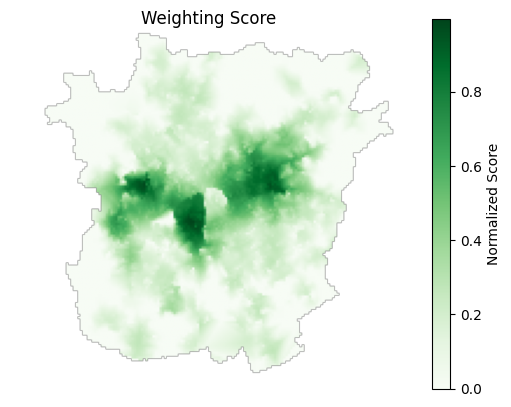

In [79]:
plt.imshow(weight_raster,cmap='Greens')
plt.axis('off')
plt.colorbar(label='Normalized Score')
plt.xlabel('Longitude'); plt.ylabel('Latitude')
plt.title('Weighting Score')
plt.show()

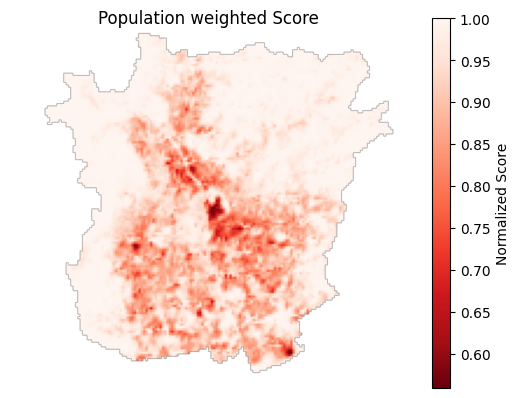

In [80]:
plt.imshow(weight_pop,cmap='Reds_r')
plt.axis('off')
plt.colorbar(label='Normalized Score')
plt.xlabel('Longitude'); plt.ylabel('Latitude')
plt.title('Population weighted Score')
plt.show()

### Calculate Statistics for Districts

In [81]:
def vectorize(data_path):    
    #vectorize raster for further calculations
    with rasterio.open(data_path) as src:
        data = src.read(1)
        results = (
            {'properties': {'value': v}, 'geometry': s}
            for i, (s, v) in enumerate(
                shapes(data, transform=src.transform)
            )
        )

    geoms = list(results)
    gdf_pop_weight = gpd.GeoDataFrame.from_features(geoms, crs=CRS_METRIC)

    #clean data for irregular values
    gdf_pop_weight = gdf_pop_weight[gdf_pop_weight['value'] != -9999]
    gdf_pop_weight.reset_index(drop=True, inplace=True)

    return gdf_pop_weight



In [82]:
#spatial join for mean values for districts
def calculate_district_means(pop_raster_path):
    gdf_pop_weight = vectorize(pop_raster_path)
    joined = gpd.sjoin(districts, gdf_pop_weight, how='left', predicate='intersects')
    district_means = joined.groupby('name')['value'].mean().round(3)

    districts_stats = districts.merge(district_means, left_on='name', right_on='name', how='left')
    districts_stats=districts_stats[['geometry','name','value']]
    return districts_stats, gdf_pop_weight

In [83]:
weighted_pop_tif = DIR_RASTER / 'weighted_pop.tif'
district_pop_weights, gdf_pop_weight = calculate_district_means(weighted_pop_tif)
print(f"✓ District means calculated from: {weighted_pop_tif}")

✓ District means calculated from: data\raster\weighted_pop.tif


In [84]:
cost_map = KeplerGl(height=600)
cost_map.add_data(data=districts, name="Districts")  
cost_map.add_data(data=gdf_pop_weight, name="Population weighted cost")  
cost_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Districts': {'index': [('relation', 102537), ('relation', 102546), ('relation', 102553), ('rel…

In [85]:
district_map = KeplerGl(height=600) 
district_map.add_data(data=district_pop_weights, name="District population weights")  
district_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'District population weights': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

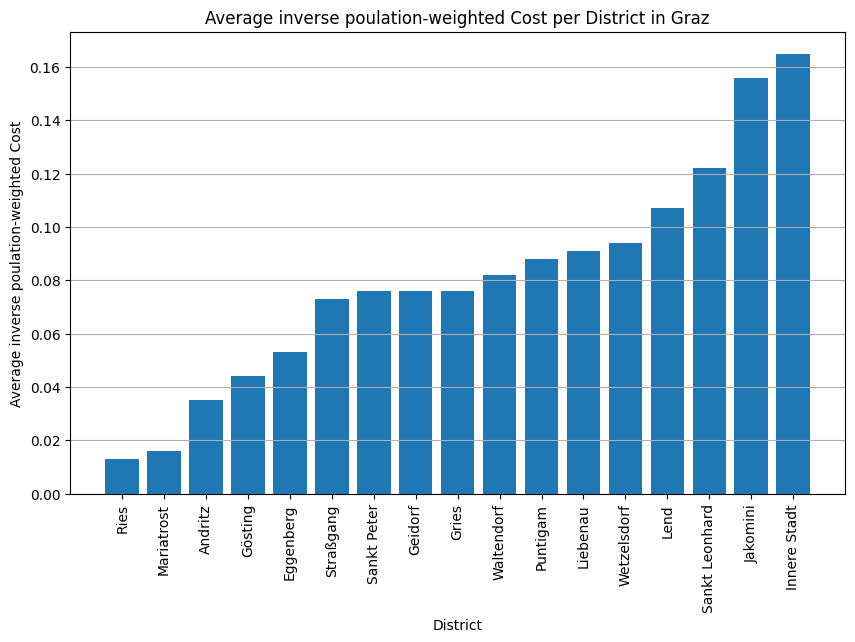

In [86]:
#plot statistics as bar chart with vertical labels
district_pop_weights = district_pop_weights.sort_values('value', ascending=False).reset_index(drop=True)
district_pop_weights['inv_value']=1-district_pop_weights['value']

plt.figure(figsize=(10,6))
plt.bar(district_pop_weights['name'], district_pop_weights['inv_value'])
plt.xlabel('District')
plt.ylabel('Average inverse poulation-weighted Cost')
plt.grid(axis='y')
plt.title('Average inverse poulation-weighted Cost per District in Graz')
plt.xticks(rotation=90)
plt.show()

## Step 5: Optimal Facility Placement

Find the optimal location and type for a new medical facility that maximizes improvement in the overall population-weighted accessibility score.

**Approach:**
1. Generate candidate locations from underserved areas (low accessibility nodes)
2. For each candidate, test adding each facility type (hospital, clinic, doctor, pharmacy)
3. Calculate the improvement in overall accessibility score
4. Select the best (location, type) combination
5. Visualize results

In [87]:
# Helper function: Calculate score improvement when adding a new facility
def calculate_score_with_new_facility(nodes_base, new_node_id, facility_type, street_graph):
    """
    Calculate new accessibility scores after adding a facility at a network node.
    
    Args:
        nodes_base: nodes GeoDataFrame with existing dist_* and score_* columns
        new_node_id: graph node ID where new facility will be placed
        facility_type: 'hospital', 'clinic', 'doctor', or 'pharmacy'
        street_graph: the street network graph
    Returns:
        Updated nodes GeoDataFrame with new scores
    """
    nodes_new = nodes_base.copy()
    dist_col = f'dist_{facility_type}'
    score_col = f'score_{facility_type}'
    
    # Calculate network distances from new facility to all nodes using Dijkstra
    new_distances = nx.single_source_dijkstra_path_length(street_graph, new_node_id, weight='length')
    
    # Map to nodes dataframe
    new_dist_series = nodes_new['graph_node'].map(new_distances)
    
    # Update distance (take minimum of existing and new)
    nodes_new[dist_col] = np.minimum(nodes_new[dist_col], new_dist_series)
    
    # Recalculate score for this facility type
    nodes_new[score_col] = score(nodes_new[dist_col], MAX_DIST[facility_type], WEIGHTS[facility_type])
    
    # Recalculate aggregate scores
    nodes_new['facilities_sum'] = (
        nodes_new['score_hospital'] + nodes_new['score_clinic'] +
        nodes_new['score_doctor'] + nodes_new['score_pharmacy']
    )
    nodes_new['access_score'] = nodes_new['facilities_sum']
    nodes_new['access_norm'] = nodes_new['access_score'] / nodes_new['access_score'].max()
    
    return nodes_new


def generate_candidates(nodes_scores, threshold_percentile=30, sample_size=200):
    """
    Generate candidate locations from underserved areas.
    
    Args:
        nodes_scores: GeoDataFrame with access_norm column
        threshold_percentile: nodes below this percentile are "underserved"
        sample_size: max candidates to return
    Returns:
        GeoDataFrame of candidate locations
    """
    threshold = np.percentile(nodes_scores['access_norm'].dropna(), threshold_percentile)
    
    # Filter to underserved nodes
    underserved = nodes_scores[nodes_scores['access_norm'] < threshold].copy()
    
    # Weight by deficit (lower score = higher priority)
    underserved['deficit'] = threshold - underserved['access_norm']
    
    # Sample weighted by deficit
    if len(underserved) > sample_size:
        weights = underserved['deficit'] / underserved['deficit'].sum()
        candidates = underserved.sample(n=sample_size, weights=weights, random_state=42)
    else:
        candidates = underserved
    
    print(f"Generated {len(candidates)} candidate locations (threshold: {threshold:.3f})")
    return candidates.reset_index(drop=True)

print("Helper functions defined.")

Helper functions defined.


In [88]:
def find_optimal_facility(nodes_scores, candidates, street_graph, 
                          facility_types=['hospital', 'clinic', 'doctor', 'pharmacy'],
                          verbose=True):
    """
    Find optimal location and type for a new facility.
    
    Args:
        nodes_scores: current nodes with accessibility scores
        candidates: GeoDataFrame of candidate locations
        street_graph: the street network graph
        facility_types: list of facility types to test
    Returns:
        dict with keys: node_id, location (Point), type (str), improvement (float), new_score (float)
    """
    # Calculate baseline overall score
    baseline_score = calculate_overall_score(nodes_scores)[0]
    
    best = {
        'node_id': None,
        'location': None, 
        'type': None, 
        'improvement': 0, 
        'new_score': baseline_score,
        'baseline_score': baseline_score
    }
    
    total_tests = len(candidates) * len(facility_types)
    test_count = 0
    
    for ftype in facility_types:
        if verbose:
            print(f"\nTesting {ftype} placements ({len(candidates)} candidates)...")
        
        for idx, row in candidates.iterrows():
            test_count += 1
            node_id = row['graph_node']
            
            # Calculate new scores with this facility
            nodes_new = calculate_score_with_new_facility(nodes_scores, node_id, ftype, street_graph)
            new_overall = calculate_overall_score(nodes_new)[0]
            improvement = new_overall - baseline_score
            
            if improvement > best['improvement']:
                best = {
                    'node_id': node_id,
                    'location': row.geometry,
                    'type': ftype,
                    'improvement': improvement,
                    'new_score': new_overall,
                    'baseline_score': baseline_score
                }
                if verbose:
                    print(f"  New best: {ftype} at node {node_id}, improvement: {improvement*100:.4f}%")
            
            # Progress update
            if verbose and test_count % 100 == 0:
                print(f"  Progress: {test_count}/{total_tests} ({100*test_count/total_tests:.1f}%)")
    
    return best

print("Optimization function defined.")

Optimization function defined.


In [89]:
# Generate candidate locations from underserved areas
candidates = generate_candidates(nodes_scores, threshold_percentile=30, sample_size=150)

# Preview candidates
print(f"\nCandidate statistics:")
print(candidates[['access_norm', 'deficit']].describe())

Generated 150 candidate locations (threshold: 0.171)

Candidate statistics:
       access_norm     deficit
count   150.000000  150.000000
mean      0.030072    0.141371
std       0.041687    0.041687
min       0.000000    0.011530
25%       0.000000    0.114238
50%       0.000000    0.171443
75%       0.057205    0.171443
max       0.159913    0.171443


In [90]:
# Run optimization to find best facility location and type
# Note: This may take a few minutes depending on candidate count

print("="*60)
print("STARTING OPTIMIZATION")
print("="*60)

optimal = find_optimal_facility(
    nodes_scores, 
    candidates, 
    street_graph,
    facility_types=['hospital', 'clinic', 'doctor', 'pharmacy']
)

print("\n" + "="*60)
print("OPTIMIZATION RESULTS")
print("="*60)
print(f"Optimal facility type: {optimal['type']}")
print(f"Optimal location (node ID): {optimal['node_id']}")
print(f"Optimal location (coords): ({optimal['location'].x:.2f}, {optimal['location'].y:.2f})")
print(f"Baseline score: {optimal['baseline_score']*100:.2f}%")
print(f"New score: {optimal['new_score']*100:.2f}%")
print(f"Improvement: {optimal['improvement']*100:.4f}%")
print("="*60)

STARTING OPTIMIZATION

Testing hospital placements (150 candidates)...
  New best: hospital at node 1952487430, improvement: 0.0227%
  New best: hospital at node 6894150187, improvement: 0.1973%
  New best: hospital at node 6217142685, improvement: 0.3331%
  New best: hospital at node 970995618, improvement: 0.3396%
  New best: hospital at node 269573460, improvement: 0.3922%
  New best: hospital at node 5256265815, improvement: 0.4081%
  New best: hospital at node 6376469278, improvement: 0.4676%
  Progress: 100/600 (16.7%)

Testing clinic placements (150 candidates)...
  Progress: 200/600 (33.3%)
  Progress: 300/600 (50.0%)

Testing doctor placements (150 candidates)...
  Progress: 400/600 (66.7%)

Testing pharmacy placements (150 candidates)...
  Progress: 500/600 (83.3%)
  Progress: 600/600 (100.0%)

OPTIMIZATION RESULTS
Optimal facility type: hospital
Optimal location (node ID): 6376469278
Optimal location (coords): (-66213.22, 213604.84)
Baseline score: 93.38%
New score: 93.85%
I

### Visualize Results

In [91]:
# Calculate "after" scores for visualization
nodes_after = calculate_score_with_new_facility(
    nodes_scores, 
    optimal['node_id'], 
    optimal['type'], 
    street_graph
)

# Calculate improvement per node
nodes_scores['improvement'] = nodes_after['access_norm'] - nodes_scores['access_norm']

# Create optimal location GeoDataFrame
# Note: optimal['location'] is already in CRS_METRIC (from nodes_scores)
optimal_point = gpd.GeoDataFrame(
    {'type': [optimal['type']], 'geometry': [optimal['location']]}, 
    crs=CRS_METRIC  # geometry is already in metric CRS
)

print(f"Optimal location CRS: {optimal_point.crs}")
print(f"Optimal location coords: ({optimal_point.geometry.iloc[0].x:.2f}, {optimal_point.geometry.iloc[0].y:.2f})")
print(f"\nImprovement statistics:")
print(nodes_scores['improvement'].describe())

Optimal location CRS: EPSG:31256
Optimal location coords: (-66213.22, 213604.84)

Improvement statistics:
count    39465.000000
mean         0.052208
std          0.131660
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.561715
Name: improvement, dtype: float64


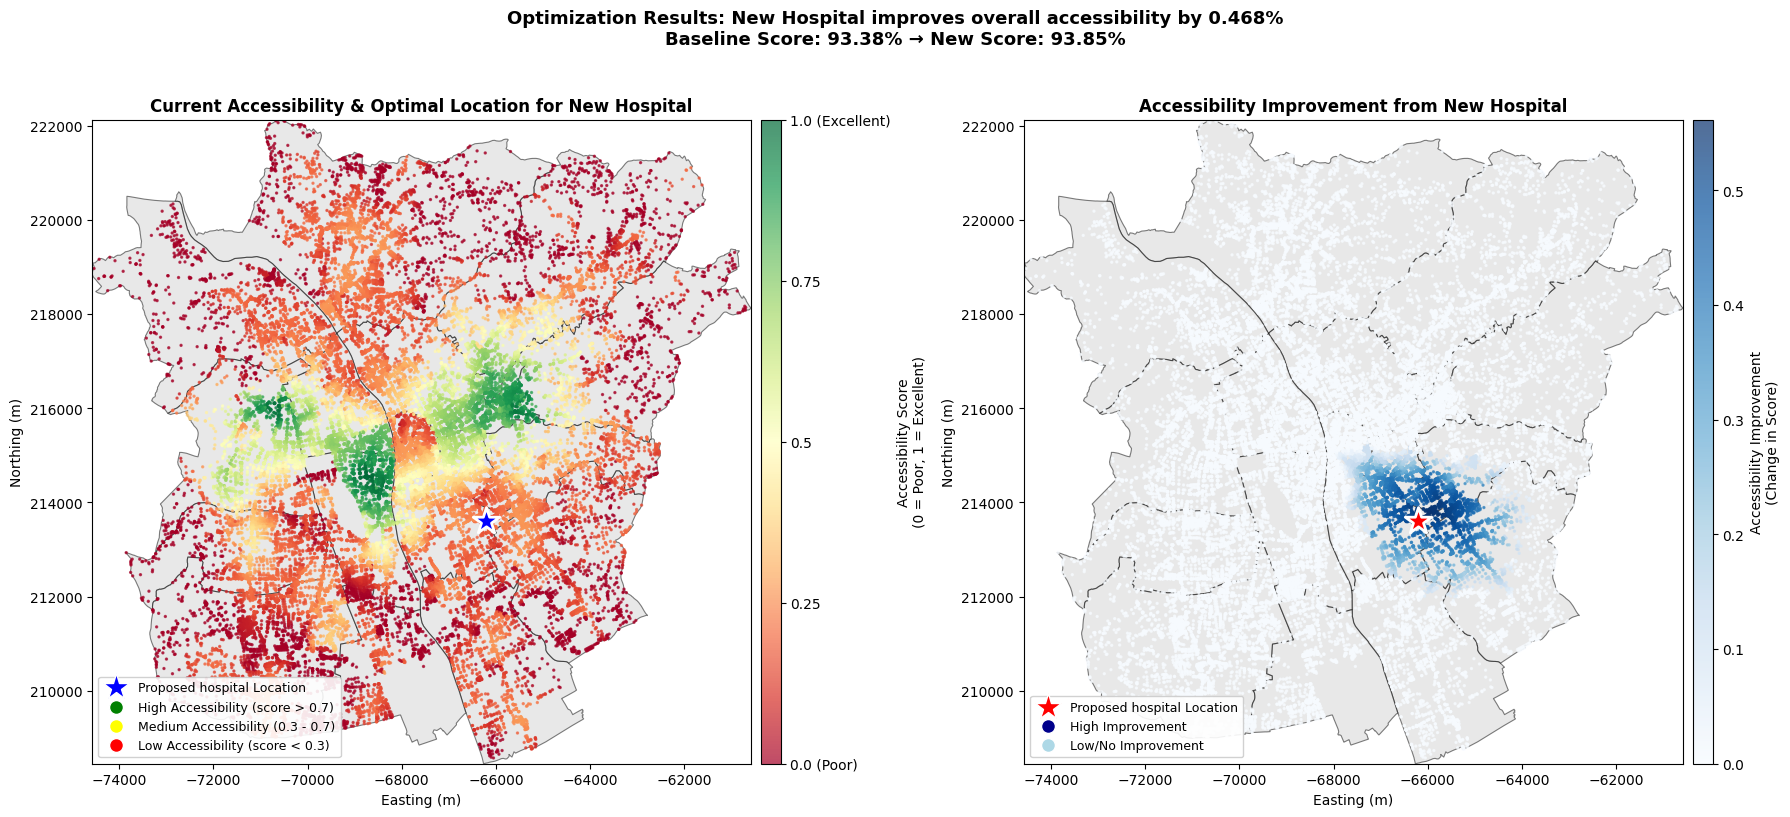

✓ Optimization visualization saved to: data\output\maps\optimization_results.png


In [92]:
# Visualization: Optimal location and improvement map with proper legends
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Convert nodes to metric CRS for plotting
nodes_plot = nodes_scores.to_crs(CRS_METRIC)

# ============ Plot 1: Current Accessibility with Optimal Location ============
ax1 = axes[0]
districts.plot(ax=ax1, color='lightgray', edgecolor='black', alpha=0.5, linewidth=0.8)

# Plot nodes colored by accessibility score
scatter1 = ax1.scatter(
    nodes_plot.geometry.x, nodes_plot.geometry.y,
    c=nodes_plot['access_norm'], cmap='RdYlGn', s=2, alpha=0.7,
    vmin=0, vmax=1
)

# Add colorbar with explanation
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="3%", pad=0.1)
cbar1 = plt.colorbar(scatter1, cax=cax1)
cbar1.set_label('Accessibility Score\n(0 = Poor, 1 = Excellent)', fontsize=10)
cbar1.set_ticks([0, 0.25, 0.5, 0.75, 1.0])
cbar1.set_ticklabels(['0.0 (Poor)', '0.25', '0.5', '0.75', '1.0 (Excellent)'])

# Plot optimal location
optimal_point.plot(ax=ax1, color='blue', markersize=400, marker='*', 
                   edgecolor='white', linewidth=2, zorder=10)

ax1.set_xlim(bounds[0], bounds[2])
ax1.set_ylim(bounds[1], bounds[3])
ax1.set_title(f'Current Accessibility & Optimal Location for New {optimal["type"].title()}', 
              fontsize=12, fontweight='bold')
ax1.set_xlabel('Easting (m)', fontsize=10)
ax1.set_ylabel('Northing (m)', fontsize=10)

# Custom legend
legend_elements1 = [
    Line2D([0], [0], marker='*', color='w', markerfacecolor='blue', 
           markersize=20, markeredgecolor='white', label=f'Proposed {optimal["type"]} Location'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', 
           markersize=10, label='High Accessibility (score > 0.7)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', 
           markersize=10, label='Medium Accessibility (0.3 - 0.7)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
           markersize=10, label='Low Accessibility (score < 0.3)'),
]
ax1.legend(handles=legend_elements1, loc='lower left', fontsize=9, framealpha=0.9)

# ============ Plot 2: Improvement Heatmap ============
ax2 = axes[1]
districts.plot(ax=ax2, color='lightgray', edgecolor='black', alpha=0.5, linewidth=0.8)

# Plot nodes colored by improvement
max_improvement = nodes_plot['improvement'].max()
scatter2 = ax2.scatter(
    nodes_plot.geometry.x, nodes_plot.geometry.y,
    c=nodes_plot['improvement'], cmap='Blues', s=2, alpha=0.7,
    vmin=0, vmax=max_improvement
)

# Add colorbar with explanation
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="3%", pad=0.1)
cbar2 = plt.colorbar(scatter2, cax=cax2)
cbar2.set_label(f'Accessibility Improvement\n(Change in Score)', fontsize=10)

# Plot optimal location
optimal_point.plot(ax=ax2, color='red', markersize=400, marker='*', 
                   edgecolor='white', linewidth=2, zorder=10)

ax2.set_xlim(bounds[0], bounds[2])
ax2.set_ylim(bounds[1], bounds[3])
ax2.set_title(f'Accessibility Improvement from New {optimal["type"].title()}', 
              fontsize=12, fontweight='bold')
ax2.set_xlabel('Easting (m)', fontsize=10)
ax2.set_ylabel('Northing (m)', fontsize=10)

# Custom legend
legend_elements2 = [
    Line2D([0], [0], marker='*', color='w', markerfacecolor='red', 
           markersize=20, markeredgecolor='white', label=f'Proposed {optimal["type"]} Location'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='darkblue', 
           markersize=10, label='High Improvement'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', 
           markersize=10, label='Low/No Improvement'),
]
ax2.legend(handles=legend_elements2, loc='lower left', fontsize=9, framealpha=0.9)

# Add overall annotation
fig.suptitle(
    f'Optimization Results: New {optimal["type"].title()} improves overall accessibility by {optimal["improvement"]*100:.3f}%\n'
    f'Baseline Score: {optimal["baseline_score"]*100:.2f}% → New Score: {optimal["new_score"]*100:.2f}%',
    fontsize=13, fontweight='bold', y=1.02
)

plt.tight_layout()
plt.savefig(DIR_MAPS / 'optimization_results.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Optimization visualization saved to: {DIR_MAPS / 'optimization_results.png'}")

In [93]:
# District-level before/after comparison
nodes_gdf_after = gpd.GeoDataFrame(nodes_after, geometry='geometry', crs=CRS_METRIC)

# Spatial join to districts
nodes_with_district_after = gpd.sjoin(
    nodes_gdf_after,
    districts[['name', 'geometry']],
    how='left',
    predicate='within'
)

# Calculate mean accessibility per district (after)
district_access_after = (
    nodes_with_district_after
    .groupby('name')['access_norm']
    .mean()
    .reset_index(name='mean_access_after')
)

# Merge with before scores
district_comparison = district_access.merge(district_access_after, on='name')
district_comparison['improvement'] = district_comparison['mean_access_after'] - district_comparison['mean_access']
district_comparison = district_comparison.sort_values('improvement', ascending=False)

print("District-level improvement from new facility:")
print(district_comparison[['name', 'mean_access', 'mean_access_after', 'improvement']].to_string(index=False))

District-level improvement from new facility:
          name  mean_access  mean_access_after  improvement
      Jakomini     0.305440           0.560415     0.254974
   Sankt Peter     0.138318           0.351222     0.212903
    Waltendorf     0.300055           0.496286     0.196231
Sankt Leonhard     0.527345           0.722860     0.195514
  Innere Stadt     0.313969           0.353891     0.039921
      Liebenau     0.134603           0.138399     0.003796
       Andritz     0.153249           0.153249     0.000000
       Gösting     0.129565           0.129565     0.000000
     Eggenberg     0.525421           0.525421     0.000000
          Lend     0.540998           0.540998     0.000000
       Geidorf     0.566187           0.566187     0.000000
         Gries     0.534665           0.534665     0.000000
    Mariatrost     0.301093           0.301093     0.000000
          Ries     0.365394           0.365394     0.000000
      Puntigam     0.080763           0.080763     0.0

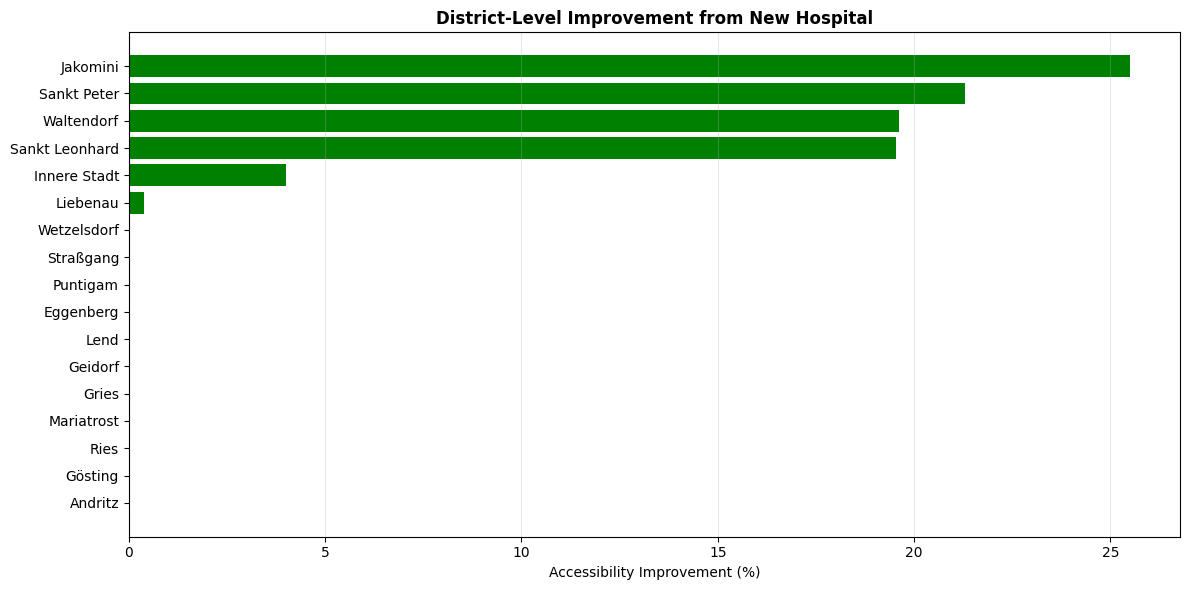

✓ District improvement chart saved to: data\output\charts\district_improvement.png


In [94]:
# Bar chart: District improvement comparison
fig, ax = plt.subplots(figsize=(12, 6))

district_comparison_sorted = district_comparison.sort_values('improvement', ascending=True)
colors = ['green' if x > 0 else 'gray' for x in district_comparison_sorted['improvement']]

ax.barh(district_comparison_sorted['name'], district_comparison_sorted['improvement'] * 100, color=colors)
ax.axvline(x=0, color='black', linewidth=0.5)
ax.set_xlabel('Accessibility Improvement (%)')
ax.set_title(f'District-Level Improvement from New {optimal["type"].title()}', fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(DIR_CHARTS / 'district_improvement.png', dpi=150)
plt.show()

print(f"✓ District improvement chart saved to: {DIR_CHARTS / 'district_improvement.png'}")

In [95]:
# Interactive map with KeplerGL - Optimization Results
# Prepare data for KeplerGL (requires WGS84)

# Convert optimal location to WGS84
optimal_wgs = optimal_point.to_crs('EPSG:4326')
opt_lat, opt_lon = optimal_wgs.geometry.iloc[0].y, optimal_wgs.geometry.iloc[0].x

print(f"Optimal location (WGS84): {opt_lat:.6f}, {opt_lon:.6f}")

# Prepare nodes with scores for visualization (sample for performance)
nodes_viz = nodes_scores.copy()
nodes_viz = nodes_viz.to_crs('EPSG:4326')
# Sample nodes for better performance in KeplerGL
nodes_viz_sample = nodes_viz.sample(n=min(5000, len(nodes_viz)), random_state=42)
nodes_viz_sample = nodes_viz_sample[['geometry', 'access_norm', 'improvement']].copy()
nodes_viz_sample['access_pct'] = (nodes_viz_sample['access_norm'] * 100).round(1)
nodes_viz_sample['improvement_pct'] = (nodes_viz_sample['improvement'] * 100).round(3)

# Prepare optimal location as separate layer
optimal_location_df = gpd.GeoDataFrame({
    'name': [f"Proposed {optimal['type']}"],
    'type': [optimal['type']],
    'improvement_pct': [round(optimal['improvement'] * 100, 3)],
    'geometry': [optimal_wgs.geometry.iloc[0]]
}, crs='EPSG:4326')

# Prepare existing facilities of same type
existing_same_type = medical[medical['type'] == optimal['type']].to_crs('EPSG:4326')
existing_same_type = existing_same_type[['name', 'type', 'geometry']].copy()

# Create KeplerGL map
optimization_map = KeplerGl(height=700)

# Add layers
optimization_map.add_data(data=districts_wgs, name="Districts")
optimization_map.add_data(data=nodes_viz_sample, name="Accessibility Scores")
optimization_map.add_data(data=existing_same_type, name=f"Existing {optimal['type']}s")
optimization_map.add_data(data=optimal_location_df, name="Optimal New Location")

print(f"KeplerGL map created with {len(nodes_viz_sample)} sampled nodes")
print(f"\nLayers added:")
print(f"  - Districts (boundaries)")
print(f"  - Accessibility Scores (color by access_pct or improvement_pct)")
print(f"  - Existing {optimal['type']}s ({len(existing_same_type)} locations)")
print(f"  - Optimal New Location (proposed facility)")

optimization_map

Optimal location (WGS84): 47.058248, 15.460684
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
KeplerGL map created with 5000 sampled nodes

Layers added:
  - Districts (boundaries)
  - Accessibility Scores (color by access_pct or improvement_pct)
  - Existing hospitals (0 locations)
  - Optimal New Location (proposed facility)


KeplerGl(data={'Districts': {'index': [('relation', 102537), ('relation', 102546), ('relation', 102553), ('rel…

In [96]:
# Final Summary
print("="*70)
print("STEP 5 COMPLETE: OPTIMAL FACILITY PLACEMENT")
print("="*70)
print(f"\nRecommendation: Build a new {optimal['type'].upper()}")
print(f"Location: Node {optimal['node_id']}")
print(f"Coordinates (EPSG:31256): ({optimal['location'].x:.2f}, {optimal['location'].y:.2f})")
print(f"Coordinates (WGS84): ({opt_lat:.6f}, {opt_lon:.6f})")
print(f"\nImpact:")
print(f"  - Baseline accessibility score: {optimal['baseline_score']*100:.2f}%")
print(f"  - New accessibility score: {optimal['new_score']*100:.2f}%")
print(f"  - Improvement: +{optimal['improvement']*100:.4f}%")
print(f"\nMost improved districts:")
top_improved = district_comparison.nlargest(3, 'improvement')
for _, row in top_improved.iterrows():
    print(f"  - {row['name']}: +{row['improvement']*100:.4f}%")
print(f"\nAccessibility Score Interpretation:")
print(f"  - Score 0.0: No medical facilities within acceptable distance")
print(f"  - Score 0.5: Moderate access (some facility types within range)")
print(f"  - Score 1.0: Excellent access (all facility types nearby)")
print(f"\nOutputs saved to:")
print(f"  - {DIR_MAPS / 'optimization_results.png'}")
print(f"  - {DIR_CHARTS / 'district_improvement.png'}")
print(f"  - KeplerGL interactive map (displayed above)")
print("="*70)

STEP 5 COMPLETE: OPTIMAL FACILITY PLACEMENT

Recommendation: Build a new HOSPITAL
Location: Node 6376469278
Coordinates (EPSG:31256): (-66213.22, 213604.84)
Coordinates (WGS84): (47.058248, 15.460684)

Impact:
  - Baseline accessibility score: 93.38%
  - New accessibility score: 93.85%
  - Improvement: +0.4676%

Most improved districts:
  - Jakomini: +25.4974%
  - Sankt Peter: +21.2903%
  - Waltendorf: +19.6231%

Accessibility Score Interpretation:
  - Score 0.0: No medical facilities within acceptable distance
  - Score 0.5: Moderate access (some facility types within range)
  - Score 1.0: Excellent access (all facility types nearby)

Outputs saved to:
  - data\output\maps\optimization_results.png
  - data\output\charts\district_improvement.png
  - KeplerGL interactive map (displayed above)
